In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
# create a module to normalize input image so we can easily put it into network
class Normalization(nn.Module):
    def __init__(self, default_mean_std = True):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        self.default_mean_std = default_mean_std

    def forward(self, imgs):
        # get the size of the images
        b, c, h, w = imgs.size()

        if not self.default_mean_std:
            # get the mean and std from the batch of the imgs
            self.std, self.mean = self.get_std_and_mean(imgs, b, c)

        # view the mean and std, so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        self.mean = torch.tensor(self.mean).view(b, c, 1, 1)
        self.std = torch.tensor(self.std).view(b, c, 1, 1)

        # normalize img
        eplison = 1e-5 # used to avoid dividing zero
        return (imgs - self.mean) / (self.std + eplison)

    def get_std_and_mean(self, imgs, b = 1, c = 3):
        """ Get the mean and std from the batch of the imgs

        input:
            imgs (tensor): size: batch, channel, height, weight
            b (int): batch_size
            c (int): channel_size, usually 3 (RGB)
        output:
            mean (tensor): size: batch, channel 
            mean (tensor): size: batch, channel 
        """
        # calculate the mean
        std, mean = torch.std_mean(imgs.view(b, c, -1), 2)
        return std, mean


In [64]:
class ContentLoss(nn.Module):
    """
    create a dummy layer into the network, it does nothing but records the content loss 
    """
    def __init__(self, target_content):
        super(ContentLoss, self).__init__()
        self.target_content = target_content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.target_content)
        return x

In [65]:
class StyleLoss(nn.Module):
    """
    create a dummy layer into the network, it does nothing but records the styleloss 
    """
    def __init__(self, target_tyle):
        super(StyleLoss, self).__init__()
        self.A = self.gram_matrix(target_tyle).detach()

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = F.mse_loss(G, self.A)
        return x

    def gram_matrix(self, x):
        """ Calculate the gram martix based on the input tensor

        input:
            x (tensor): size: b, c, h, w

        output:
            gram (tensor): size: b*c, b*c
        """
        # get input's dimension
        b, c, h, w = x.size()

        # calculate the gram martix
        features = x.view(b * c, h * w)
        G = torch.mm(features, features.t())

        return G.div(b * c * h * w)

In [66]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("p1.jpg")
content_img = image_loader("xu.jpg")

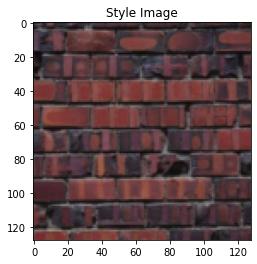

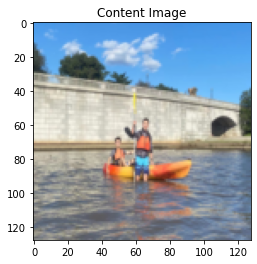

In [67]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [68]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [69]:
# desired depth layers to compute style/content losses:
default_content_layers = ['conv_4']
default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [70]:
def generate_model(pre_model, style_img, content_img,
                   default_mean_std = True,
                   content_layers=default_content_layers,
                   style_layers=default_style_layers):

    """ create the model for trainning
        input: 
            pre_model: the pretrain model
            style_img: the style image
            default_mean_std (bool): used the default value or not
            content_img: the content image
            content_layers (list): the layers we want to extract content 
            style_layers (list): the layers we want to extract style 

        output:
            model: style transfer model
            content_losses (list): store the content loss dummy layers
            style_losses (list): store the style loss dummy layers
    """

    cnn = copy.deepcopy(pre_model)

    # normalization module
    normalization = Normalization(default_mean_std = default_mean_std)

    # used to access dummmy layer
    content_losses = []
    style_losses = []

    # create our model
    model = nn.Sequential(normalization)

    # increment every time we see a conv
    i = 0  
    # go through all the layers
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # According to Alexis Jacq, the in-place version doesn't play 
            # very nicely with the ContentLoss with the ContentLoss and StyleLoss 
            # we insert below. So we replace with out-of-place ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'maxpool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            # calculate target content
            target_content = model(content_img).detach()
            # save target content
            content_loss = ContentLoss(target_content)
            # add one layer
            model.add_module("content_loss_{}".format(i), content_loss)
            # save the layer in the list
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            # calculate target style
            target_style = model(style_img).detach()
            # save target style
            style_loss = StyleLoss(target_style)
            # add one layer
            model.add_module("style_loss_{}".format(i), style_loss)
            # save the layer in the list
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [71]:
def style_transfer(model, content_img, style_img, input_img, 
                   default_mean_std = True,
                   num_steps=300, style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')

    model, style_losses, content_losses = generate_model(cnn, style_img, content_img, default_mean_std = True)
    #optimizer = get_input_optimizer(input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    print('Optimizing..')
    
    run = [0]
    def closure():
        # correct the values of updated input image
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        # extract the losses
        for sl in style_losses:
            style_score += sl.loss / len(style_losses)
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score

        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            print()

        return style_score + content_score

    while run[0] <= num_steps:
        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img, model(input_img)

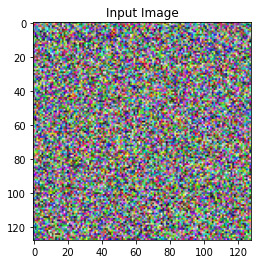

In [72]:
## choose content image as input
input_img = content_img.clone()
# the noise input 
input_img = torch.randn(content_img.data.size(), device=device)
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 33.875786 Content Loss: 39.396942

run [100]:
Style Loss : 10.761106 Content Loss: 29.978851

run [150]:
Style Loss : 5.496843 Content Loss: 24.025555

run [200]:
Style Loss : 3.566416 Content Loss: 20.628048

run [250]:
Style Loss : 2.994830 Content Loss: 18.638763

run [300]:
Style Loss : 2.815288 Content Loss: 17.057226



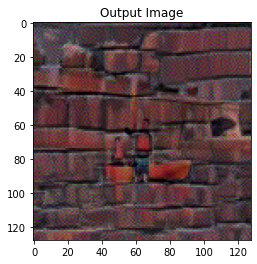

In [73]:
output, g = style_transfer(cnn, content_img, style_img, input_img, default_mean_std = False,
                        num_steps=300, style_weight=1000000, content_weight=1)
                            
plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

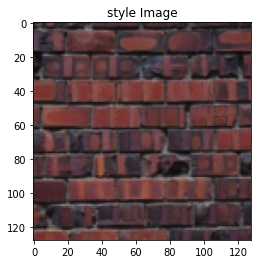

In [74]:
imshow(style_img, title='style Image')

In [75]:
torchvision.utils.save_image(output, 'r4.jpg')

In [76]:
g.size()

torch.Size([1, 256, 32, 32])